In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import space, gp_minimize
from functools import partial
import math
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/regression/Real estate train.csv')
train.drop('Unnamed: 0', inplace=True, axis=1)

In [3]:
class LinearReg:
    def fit(self, X, y):
        X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        prod_1 = np.matmul(X.transpose(), X)
        if (np.linalg.det(prod_1) != 0):
            prod_2 = np.matmul(np.linalg.inv(prod_1), X.transpose())
        else:
            prod_2 = np.matmul(np.linalg.pinv(prod_1), X.transpose())
        self.beta = np.matmul(prod_2, y)
    
    def predict(self, X_test):
        tmp = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)
        return np.matmul(tmp, self.beta)

In [4]:
class RidgeReg(float):
    def __init__(self, l):
        self.l = l

    def fit(self, X, y):
        identity_matrix = np.identity(X.shape[1])
        prod_1 = np.matmul(X.transpose(), X)
        prod_2 = self.l * identity_matrix
        term_1 = np.add(prod_1, prod_2)
        prod_3 = np.matmul(np.linalg.inv(term_1), X.transpose())

        center_function = lambda x: x - x.mean()
        y_centered = center_function(y)
        self.y_mean = y.mean()

        self.beta_rdige = np.matmul(prod_3, y_centered)
    
    def predict(self, X_test):
        inverse_center = lambda x: x + self.y_mean
        return inverse_center(np.matmul(X_test, self.beta_rdige))

In [5]:
X_train = train.drop('target', axis=1)
y_train = train['target']

test = pd.read_csv('../data/regression/Real estate test.csv')
test.drop('Unnamed: 0', inplace=True, axis=1)
X_test = test.drop('target', axis=1)
y_test = test['target']


In [6]:
sk_linreg = LinearRegression()
sk_linreg.fit(X_train, y_train)
y_pred = sk_linreg.predict(X_test)


linreg = LinearReg()
linreg.fit(X_train.values, y_train.values)
y_pred_manual = linreg.predict(X_test.values)

print("Sklearn's Linear Regression: ")
print("R2: ", r2_score(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))
print("---------------------")
print("Manual Implementation of Linear Regression: ")
print("R2: ", r2_score(y_test, y_pred_manual))
print("MAE: ", mean_absolute_error(y_test, y_pred_manual))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_manual)))

Sklearn's Linear Regression: 
R2:  0.6974280661583803
MAE:  4.432079085527505
RMSE:  5.891202699857207
---------------------
Manual Implementation of Linear Regression: 
R2:  0.6974280661583803
MAE:  4.432079085527506
RMSE:  5.891202699857207


In [7]:
sk_ridge = Ridge(alpha=1)
sk_ridge.fit(X_train.values, y_train.values)
y_pred_ridge = sk_ridge.predict(X_test.values)


ridge_manual = RidgeReg(l = 1)
ridge_manual.fit(X_train.values, y_train.values)
y_pred_ridge_manual = ridge_manual.predict(X_test.values)

print("Sklearn's Ridge: ")
print("R2: ", r2_score(y_test, y_pred_ridge))
print("MAE: ", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("---------------------")
print("Manual Implementation of Ridge Regression: ")
print("R2: ", r2_score(y_test, y_pred_ridge_manual))
print("MAE: ", mean_absolute_error(y_test, y_pred_ridge_manual))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_ridge_manual)))

Sklearn's Ridge: 
R2:  0.6974584605943199
MAE:  4.436143767402348
RMSE:  5.890906796205766
---------------------
Manual Implementation of Ridge Regression: 
R2:  0.6974584605943212
MAE:  4.436143767402327
RMSE:  5.890906796205755


In [8]:
def optimize(par, x, y):
    model = RidgeReg(l=par)
    kf = KFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]

        xtest = x[test_idx]
        ytest = y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        fold_acc = r2_score(ytest, preds)
        accuracies.append(fold_acc)
    
    return -1.0 * np.mean(accuracies)

In [9]:
max=0
best_param=0
mean_fold_accs = []
for i in range(0,20):
    res = optimize(par=i, x=X_train.values, y=y_train.values)
    mean_fold_accs.append(-res)
    if (max > res):
        max=res
        best_param=i

print("Best hyperparameter: ", best_param)
print("Highest R2 Score on the folds: ", -max)

Best hyperparameter:  11
Highest R2 Score on the folds:  0.6469289355500194


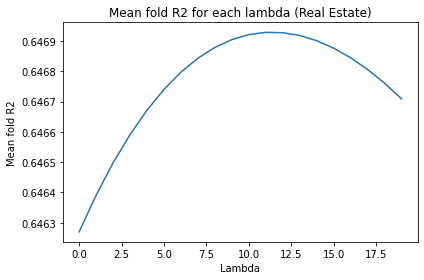

In [10]:
x_vals = list(range(0,20))

plt.plot(x_vals, mean_fold_accs)
plt.title("Mean fold R2 for each lambda (Real Estate)")
plt.xlabel("Lambda")
plt.ylabel("Mean fold R2")
plt.tight_layout()
plt.savefig('Mean fold R2 for each lambda (Real Estate).jpg', dpi=300, bbox_inches='tight')

In [11]:
ridge_manual = RidgeReg(l = 11)
ridge_manual.fit(X_train.values, y_train.values)
y_pred_ridge_manual = ridge_manual.predict(X_test.values)

print("Manual Implementation of Ridge Regression with Tuning: ")
print("R2: ", r2_score(y_test, y_pred_ridge_manual))
print("MAE: ", mean_absolute_error(y_test, y_pred_ridge_manual))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_ridge_manual)))
#jfjfj

Manual Implementation of Ridge Regression with Tuning: 
R2:  0.6977631832334911
MAE:  4.469390908104249
RMSE:  5.887939360881277


In [12]:
train_le = pd.read_csv('../data/regression/Life Expectancy Data train.csv')
test_le = pd.read_csv('../data/regression/Life Expectancy Data test.csv')
train_le

,Unnamed: 0,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe,Developed,Developing,label
0,2492,2012,412.0,2,0.01,720.233393,95.0,0,3.7,3,...,0,0,0,0,0,0,0,0,1,56.5
1,1222,2011,93.0,22,0.03,0.000000,99.0,73,54.8,25,...,0,0,0,0,0,0,0,0,1,74.7
2,1113,2008,218.0,1,7.32,493.327929,93.0,0,4.9,1,...,0,0,0,0,0,0,0,0,1,66.3
3,310,2009,27.0,10,3.87,0.000000,93.0,0,48.6,12,...,0,0,0,0,0,0,0,0,1,68.0
4,2552,2000,136.0,10,1.41,81.727471,79.0,146,43.9,12,...,0,0,0,0,0,0,0,0,1,72.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,599,2008,255.0,2,0.12,93.367890,81.0,0,2.6,2,...,0,0,0,0,0,0,0,0,1,61.0
2052,1599,2002,14.0,4,0.49,216.702948,95.0,408,27.9,4,...,0,0,0,0,0,0,0,0,1,72.9
2053,1361,2000,292.0,9,6.00,112.541157,99.0,245,43.9,10,...,0,0,0,0,0,0,0,0,1,63.9
2054,1547,2006,85.0,0,11.98,15345.490700,95.0,8,57.5,0,...,0,0,0,0,0,0,0,1,0,79.4


In [13]:
train_le.drop('Unnamed: 0', inplace=True, axis=1)
test_le.drop('Unnamed: 0', inplace=True, axis=1)
train_le

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe,Developed,Developing,label
0,2012,412.0,2,0.01,720.233393,95.0,0,3.7,3,92.0,...,0,0,0,0,0,0,0,0,1,56.5
1,2011,93.0,22,0.03,0.000000,99.0,73,54.8,25,99.0,...,0,0,0,0,0,0,0,0,1,74.7
2,2008,218.0,1,7.32,493.327929,93.0,0,4.9,1,93.0,...,0,0,0,0,0,0,0,0,1,66.3
3,2009,27.0,10,3.87,0.000000,93.0,0,48.6,12,92.0,...,0,0,0,0,0,0,0,0,1,68.0
4,2000,136.0,10,1.41,81.727471,79.0,146,43.9,12,86.0,...,0,0,0,0,0,0,0,0,1,72.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,2008,255.0,2,0.12,93.367890,81.0,0,2.6,2,81.0,...,0,0,0,0,0,0,0,0,1,61.0
2052,2002,14.0,4,0.49,216.702948,95.0,408,27.9,4,94.0,...,0,0,0,0,0,0,0,0,1,72.9
2053,2000,292.0,9,6.00,112.541157,99.0,245,43.9,10,96.0,...,0,0,0,0,0,0,0,0,1,63.9
2054,2006,85.0,0,11.98,15345.490700,95.0,8,57.5,0,99.0,...,0,0,0,0,0,0,0,1,0,79.4


In [14]:
X_train = train_le.drop('label', axis=1)
y_train = train_le['label']
X_test = test_le.drop('label', axis=1)
y_test = test_le['label']

In [15]:
sk_linreg = LinearRegression()
sk_linreg.fit(X_train, y_train)
y_pred = sk_linreg.predict(X_test)


linreg = LinearReg()
linreg.fit(X_train.values, y_train.values)
y_pred_manual = linreg.predict(X_test.values)

print("Sklearn's Linear Regression: ")
print("R2: ", r2_score(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))
print("---------------------")
print("Manual Implementation of Linear Regression: ")
print("R2: ", r2_score(y_test, y_pred_manual))
print("MAE: ", mean_absolute_error(y_test, y_pred_manual))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_manual)))

Sklearn's Linear Regression: 
R2:  0.9576136134317855
MAE:  1.2103681007395932
RMSE:  1.915251620071632
---------------------
Manual Implementation of Linear Regression: 
R2:  0.7743949254628175
MAE:  3.360806718418581
RMSE:  4.418624263984479


In [16]:
sk_ridge = Ridge(alpha=1)
sk_ridge.fit(X_train.values, y_train.values)
y_pred_ridge = sk_ridge.predict(X_test.values)


ridge_manual = RidgeReg(l = 1)
ridge_manual.fit(X_train.values, y_train.values)
y_pred_ridge_manual = ridge_manual.predict(X_test.values)

print("Sklearn's Ridge: ")
print("R2: ", r2_score(y_test, y_pred_ridge))
print("MAE: ", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("---------------------")
print("Manual Implementation of Ridge Regression: ")
print("R2: ", r2_score(y_test, y_pred_ridge_manual))
print("MAE: ", mean_absolute_error(y_test, y_pred_ridge_manual))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_ridge_manual)))

Sklearn's Ridge: 
R2:  0.9439589275621476
MAE:  1.4154282588942295
RMSE:  2.2022461523275076
---------------------
Manual Implementation of Ridge Regression: 
R2:  0.9390194572070975
MAE:  1.5025013413409496
RMSE:  2.2972501255392976


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.52691e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [17]:
max=0
best_param=0
mean_fold_accs = []
for i in range(1,20):
    res = optimize(par=i, x=X_train.values, y=y_train.values)
    mean_fold_accs.append(-res)
    if (max > res):
        max=res
        best_param=i

print("Best hyperparameter: ", best_param)
print("Highest R2 Score on the folds: ", -max)

Best hyperparameter:  1
Highest R2 Score on the folds:  0.9380495545353907


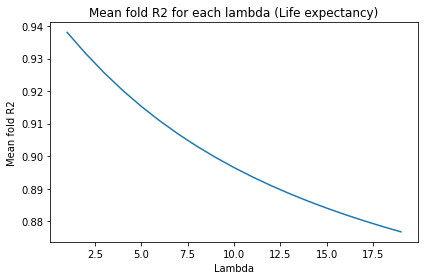

In [18]:
x_vals = list(range(1,20))

plt.plot(x_vals, mean_fold_accs)
plt.title("Mean fold R2 for each lambda (Life expectancy)")
plt.xlabel("Lambda")
plt.ylabel("Mean fold R2")
plt.tight_layout()
plt.savefig('Mean fold R2 for each lambda (Life expectancy).jpg', dpi=300, bbox_inches='tight')